<h1> Time series prediction using RNNs, with TensorFlow and Cloud ML Engine </h1>

This notebook illustrates:
<ol>
<li> Creating a Recurrent Neural Network in TensorFlow
<li> Creating a Custom Estimator in tf.contrib.learn 
<li> Training on Cloud ML Engine
</ol>

<p>

<h3> Simulate some time-series data </h3>

Essentially a set of sinusoids with random amplitudes and frequencies.

In [1]:
import tensorflow as tf
print tf.__version__

1.4.1


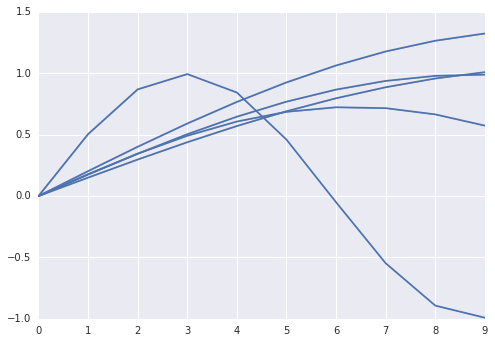

In [2]:
import numpy as np
import seaborn as sns
import pandas as pd

SEQ_LEN = 10
def create_time_series():
  freq = (np.random.random() * 0.5) + 0.1  # 0.1 to 0.6
  ampl = np.random.random() + 0.5  # 0.5 to 1.5
  x = np.sin(np.arange(0, SEQ_LEN) * freq) * ampl
  return x

for i in xrange(0, 5):
  sns.tsplot( create_time_series() );  # 5 series

In [3]:
def to_csv(filename, N):
  with open(filename, 'w') as ofp:
    for lineno in xrange(0, N):
      seq = create_time_series()
      line = ",".join(map(str, seq))
      ofp.write(line + '\n')

to_csv('train.csv', 1000)  # 1000 sequences
to_csv('valid.csv',  50)

In [4]:
!head -5 train.csv valid.csv

==> train.csv <==
0.0,0.7601097096183438,1.2874966172836428,1.4206906650395978,1.1189118291541118,0.47455574063768885,-0.31509508658106883,-1.0082732461008406,-1.3927483697329406,-1.3508057027246212
0.0,0.5567093443467932,0.9320434075066734,1.0037187718651466,0.7483836839503075,0.24922602957315843,-0.33112918624598175,-0.8036028838645835,-1.0142636615032428,-0.8944784736288417
0.0,0.6570012261760095,1.1482856631627059,1.3499356130434885,1.2110884885003286,0.766765989266397,0.12904050577874399,-0.5412331335433854,-1.0749904110685697,-1.3376006157512157
0.0,0.1596612848868046,0.3124527202474821,0.45180005002144163,0.5717074863876505,0.6670156944110085,0.7336237860885817,0.7686657719140737,0.7706338776647699,0.7394434203796859
0.0,0.5588527700404213,0.9944636387053921,1.2107688221289052,1.160067273610322,0.8535400332680578,0.3587845112758488,-0.21509253918350751,-0.7415359632536963,-1.1044509824399802

==> valid.csv <==
0.0,0.5700780216723373,1.0477580779513873,1.355618020234299,1.4437600

<h2> RNN </h2>

For more info, see:
<ol>
<li> http://colah.github.io/posts/2015-08-Understanding-LSTMs/ for the theory
<li> https://www.tensorflow.org/tutorials/recurrent for explanations
<li> https://github.com/tensorflow/models/tree/master/tutorials/rnn/ptb for sample code
</ol>

Here, we are trying to predict from 9 values of a timeseries, the tenth value.

<p>

<h3> Imports </h3>

Several tensorflow packages and shutil

In [5]:
import tensorflow as tf
import shutil
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as rnn

<h3> Input Fn to read CSV </h3>

Our CSV file structure is quite simple -- a bunch of floating point numbers (note the type of DEFAULTS). We ask for the data to be read BATCH_SIZE sequences at a time.  The Estimator API in tf.contrib.learn wants the features returned as a dict. We'll just call this timeseries column 'rawdata'.
<p>
Our CSV file sequences consist of 10 numbers. We'll assume that 9 of them are inputs and we need to predict the last one.

In [6]:
DEFAULTS = [[0.0] for x in xrange(0, SEQ_LEN)]
BATCH_SIZE = 20
TIMESERIES_COL = 'rawdata'
N_OUTPUTS = 1  # in each sequence, column index 0-8 are features, and column index 9 is label
N_INPUTS = SEQ_LEN - N_OUTPUTS

Reading data using the Estimator API in tf.learn requires an input_fn. This input_fn needs to return a dict of features and the corresponding labels.
<p>
So, we read the CSV file.  The Tensor format here will be batchsize x 1 -- entire line.  We then decode the CSV. At this point, all_data will contain a list of Tensors. Each tensor has a shape batchsize x 1.  There will be 10 of these tensors, since SEQ_LEN is 10.
<p>
We split these 10 into 9 and 1 (N_OUTPUTS is 1).  Put the 9 into a dict, call it features.  The other is the ground truth, so labels.

In [7]:
# Read data and convert to needed format
def read_dataset(filename, mode, batch_size = 512):
  def _input_fn():
    repeat_count = 100 if mode == tf.contrib.learn.ModeKeys.TRAIN else 1

    # Provide the ability to decode a CSV
    def decode_csv(line):
      # all_data is a list of tensors
      all_data = tf.decode_csv(line, record_defaults = DEFAULTS)
      inputs = all_data[:len(all_data) - N_OUTPUTS]  # first len(all_date) - N_OUTPUTS values
      label = all_data[len(all_data) - N_OUTPUTS:] # last N_OUTPUTS values

      # From list of tensors to tensor with one more dimension
      inputs = tf.expand_dims(inputs, -1)
      inputs = tf.concat(inputs, axis = 1)
      features = {TIMESERIES_COL: tf.squeeze(inputs)}
      label = tf.concat(label, axis = 1)
      label = tf.expand_dims(label, -1)

      d = features, label
      return d

    # Create list of files that match pattern
    file_list = tf.gfile.Glob(filename)

    # Create dataset from file list
    dataset = tf.data.TextLineDataset(file_list).map(decode_csv)

    if mode == tf.estimator.ModeKeys.TRAIN:
        num_epochs = None # indefinitely
        dataset = dataset.shuffle(buffer_size = 10 * batch_size)
    else:
        num_epochs = 1 # end-of-input after this

    dataset = dataset.repeat(num_epochs).batch(batch_size)

    iterator = dataset.make_one_shot_iterator()
    batch_features, batch_labels = iterator.get_next()
    return batch_features, batch_labels
  return _input_fn

<h3> Define RNN </h3>

A recursive neural network consists of possibly stacked LSTM cells.
<p>
The RNN has one output per input, so it will have 8 output cells.  We use only the last output cell, but rather use it directly, we do a matrix multiplication of that cell by a set of weights to get the actual predictions. This allows for a degree of scaling between inputs and predictions if necessary (we don't really need it in this problem).
<p>
Finally, to supply a model function to the Estimator API, you need to return a EstimatorSpec. The rest of the function creates the necessary objects.

In [8]:
LSTM_SIZE = 3  # number of hidden layers in each of the LSTM cells

# Create the inference model
def simple_rnn(features, labels, mode):
  # 0. Reformat input shape to become a sequence
  x = tf.split(features[TIMESERIES_COL], N_INPUTS, 1)
    
  # 1. Configure the RNN
  lstm_cell = rnn.BasicLSTMCell(LSTM_SIZE, forget_bias = 1.0)
  outputs, _ = rnn.static_rnn(lstm_cell, x, dtype = tf.float32)

  # Slice to keep only the last cell of the RNN
  outputs = outputs[-1]
  
  # Output is result of linear activation of last layer of RNN
  weight = tf.Variable(tf.random_normal([LSTM_SIZE, N_OUTPUTS]))
  bias = tf.Variable(tf.random_normal([N_OUTPUTS]))
  predictions = tf.matmul(outputs, weight) + bias
    
  # 2. Loss function, training/eval ops
  if mode == tf.estimator.ModeKeys.TRAIN or mode == tf.estimator.ModeKeys.EVAL:
    loss = tf.losses.mean_squared_error(labels, predictions)
    train_op = tf.contrib.layers.optimize_loss(
      loss = loss,
      global_step = tf.contrib.framework.get_global_step(),
      learning_rate = 0.01,
      optimizer = "SGD")
    eval_metric_ops = {
      "rmse": tf.metrics.root_mean_squared_error(labels, predictions)
    }
  else:
    loss = None
    train_op = None
    eval_metric_ops = None
  
  # 3. Create predictions
  predictions_dict = {"predicted": predictions}
  
  # 4. Create export outputs
  export_outputs = {"regression_export_outputs": tf.estimator.export.RegressionOutput(value = predictions)}
  
  # 5. Return EstimatorSpec
  return tf.estimator.EstimatorSpec(
      mode = mode,
      predictions = predictions_dict,
      loss = loss,
      train_op = train_op,
      eval_metric_ops = eval_metric_ops,
      export_outputs = export_outputs)

<h3> Estimator </h3>

Distributed training is launched off using an Estimator.  The key line here is that we use tf.estimator.Estimator rather than, say tf.estimator.DNNRegressor.  This allows us to provide a model_fn, which will be our RNN defined above.  Note also that we specify a serving_input_fn -- this is how we parse the input data provided to us at prediction time.

In [9]:
# Create functions to read in respective datasets
def get_train():
  return read_dataset(filename = 'train.csv', mode = tf.estimator.ModeKeys.TRAIN, batch_size = 512)

def get_valid():
  return read_dataset(filename = 'valid.csv', mode = tf.estimator.ModeKeys.EVAL, batch_size = 512)

In [10]:
# Create serving input function
def serving_input_fn():
  feature_placeholders = {
      TIMESERIES_COL: tf.placeholder(tf.float32, [None, N_INPUTS])
  }
  
  features = {
    key: tf.expand_dims(tensor, -1)
    for key, tensor in feature_placeholders.items()
  }
  features[TIMESERIES_COL] = tf.squeeze(features[TIMESERIES_COL], axis=[2])
    
  return tf.estimator.export.ServingInputReceiver(features, feature_placeholders)

In [11]:
# Create custom estimator's train and evaluate function
def train_and_evaluate(output_dir):
  estimator = tf.estimator.Estimator(model_fn = simple_rnn, 
                         model_dir = output_dir)
  train_spec = tf.estimator.TrainSpec(input_fn = get_train(),
                                    max_steps = 1000)
  exporter = tf.estimator.LatestExporter('exporter', serving_input_fn)
  eval_spec = tf.estimator.EvalSpec(input_fn = get_valid(),
                                  steps = None,
                                  exporters = exporter)
  tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

In [12]:
# Run the model
shutil.rmtree('outputdir', ignore_errors=True) # start fresh each time
train_and_evaluate('outputdir')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fdeff183750>, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': 'outputdir', '_save_summary_steps': 100}
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after 600 secs (eval_spec.throttle_secs) or training is finished.
Instructions for updating:
Please switch to tf.train.get_global_step
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into outputdir/model.ckpt.
INFO:tensorflow:loss = 1.134937, s

<h3> Standalone Python module </h3>

To train this on Cloud ML Engine, we take the code in this notebook and make a standalone Python module.

In [ ]:
%bash
# Run module as-is
echo $PWD
rm -rf outputdir
export PYTHONPATH=${PYTHONPATH}:${PWD}/simplernn
python -m trainer.task \
  --train_data_paths="${PWD}/train.csv*" \
  --eval_data_paths="${PWD}/valid.csv*"  \
  --output_dir=${PWD}/outputdir \
  --job-dir=./tmp

Try out online prediction.  This is how the REST API will work after you train on Cloud ML Engine

In [19]:
%writefile test.json
{"rawdata": [0,0.214,0.406,0.558,0.655,0.687,0.65,0.549,0.393]}

Overwriting test.json


In [20]:
%bash
MODEL_DIR=$(ls ./outputdir/export/exporter/)
gcloud ml-engine local predict --model-dir=./outputdir/export/exporter/$MODEL_DIR --json-instances=test.json

PREDICTED
[0.22933459281921387]


2017-08-23 17:39:29.901055: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.2 instructions, but these are available on your machine and could speed up CPU computations.
2017-08-23 17:39:29.901088: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX instructions, but these are available on your machine and could speed up CPU computations.
2017-08-23 17:39:29.901115: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX2 instructions, but these are available on your machine and could speed up CPU computations.
2017-08-23 17:39:29.901138: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use FMA instructions, but these are available on your machine and could speed up CPU computations.



<h3> Cloud ML Engine </h3>

Now to train on Cloud ML Engine.

In [ ]:
%bash
# Run module on Cloud ML Engine
BUCKET=cloud-training-demos-ml # CHANGE AS NEEDED
OUTDIR=gs://${BUCKET}/simplernn/model_trained
JOBNAME=simplernn_$(date -u +%y%m%d_%H%M%S)
REGION=us-central1
gsutil -m rm -rf $OUTDIR
gcloud ml-engine jobs submit training $JOBNAME \
   --region=$REGION \
   --module-name=trainer.task \
   --package-path=${PWD}/simplernn/trainer \
   --job-dir=$OUTDIR \
   --staging-bucket=gs://$BUCKET \
   --scale-tier=BASIC \
   --runtime-version=1.4 \
   -- \
   --train_data_paths="gs://${BUCKET}/train.csv*" \
   --eval_data_paths="gs://${BUCKET}/valid.csv*"  \
   --output_dir=$OUTDIR \
   --num_epochs=100

<h2> Variant: long sequence </h2>

To create short sequences from a very long sequence.

In [10]:
import tensorflow as tf
import numpy as np

def breakup(sess, x, lookback_len):
  N = sess.run(tf.size(x))
  windows = [tf.slice(x, [b], [lookback_len]) for b in xrange(0, N-lookback_len)]
  windows = tf.stack(windows)
  return windows

x = tf.constant(np.arange(1,11, dtype=np.float32))
with tf.Session() as sess:
    print 'input=', x.eval()
    seqx = breakup(sess, x, 5)
    print 'output=', seqx.eval()

input= [  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.]
output= [[ 1.  2.  3.  4.  5.]
 [ 2.  3.  4.  5.  6.]
 [ 3.  4.  5.  6.  7.]
 [ 4.  5.  6.  7.  8.]
 [ 5.  6.  7.  8.  9.]]


Copyright 2017 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License